# EE123 Lab 2: Software Defined Radio - Part II

### Written by Miki Lustig and Frank Ong

#### Intructions for Raspberry Pi (EE123 Sp'18)

All the drivers for the rtl-sdr are installed. However, you will need to install the python module for controlling the rtl-sdr.

In the commandline of a terminal on the RaspberryPi Run:

``pip3 install pyrtlsdr``

Also, you will need to install python Mode-S decoder for decoding airplane Automatic Dependent Surveillance - Broadcast (ADS-B). Run:

``pip3 install pyModeS``

Restart the Kernel.

*Please kill all other kernels before starting on this lab. The memory on the raspberryPi is limited -- and this will help speed up computation*

#### Intructions for other laptops

Before you start, you must make sure that the rtl-sdr drivers and its python support are installed. If you have not done so in the prelab, then  follow the instructions on the class website: 

https://inst.eecs.berkeley.edu/~ee123/sp18/rtl_sdr_install.html

### About the lab:

In the first part of the lab, we will look at the power spectrum of the NOAA radio signal and introduce settings of the SDR along the way. In the second part of the lab, we will decode Mode-S ADS-B packets that are transmitted by airplanes passing by, and picked up by the SDR, which allows us to track airplanes in realtime.



## About the SDR

The rtl-sdr usb dongles enables you to obtain samples from the electromagnetic spectrum around you. In very general terms, the dongle contains several components:

1. The antenna couples to received electromagnetic fields and tiny currents are produced in it. 
2. A tuner integrated circuit amplifies the signal, filters it, demodulates it to an intermediate frequency where it is filtered again. The dongles we distributed in class contain either the Refael Micro 820T (Black dongles) tuner or the Elonics E4000  (white dongles). 
3. All dongles are equipped with the realtek RTL2832U (hence rtl-sdr). Although the chip is capable of doing many things (like decoding TV in Europe), we use only its analog to digital converters and its USB interface.  The RTL2832U samples the signal that is coming from the tuner and spits out samples to the computer through the USB interface. 

The SDR returns samples at a desired rate up to 2.4MS/s (sometimes 3.5MS/s) of a part of the spectrum around a desired center frequency. For example, setting a center frequency $f_0 = 88.5\cdot 10^6$ and a sampling rate of $Fs=2\cdot 10^6$ will result in a complex valued sequence $x[n]$ whos DTFT corresponds to the physical frequency range of $87.5\cdot 10^6 < f < 89.5\cdot 10^6$. In other words, the digital frequency $\omega=0$ of $X(e^{j\omega})$, the DTFT of $x[n]$, will correspond to the physical frequency $88.5$MHz. The digital frequency $\omega=\pi$ will correspond to $89.5$MHz and $\omega=-\pi$ will correspond to $87.5$MHz.

Q) How come the sequence $x[n]$ is complex valued ??? 

A) Consider the case when there is a transmitter which outputs a pure frequency at 89MHz. We choose a center frequency of 88.5MHz and sampling rate of 2MHz. The spectrum of $x[n]$ will not be symmetric, and has to be complex valued! The received signal would be $x[n] = e^{i2\pi500000/2000000n} = e^{i\pi/2n}$ which will have a single frequency at $\omega=\pi/2$ --> corresponding to 89MHz. 



To learn about what you can do with SDR's, I  recommend you watch this youtube video. Most (not all) the stuff shown there can be done using rtl-sdr. At minute 5:00 you will see an example of ADS-B, which you will partly implement in this lab. (You will need internet connection to watch the video-- so it might not show up if you are connected to the raspberryPi via managed or ad-hoc)

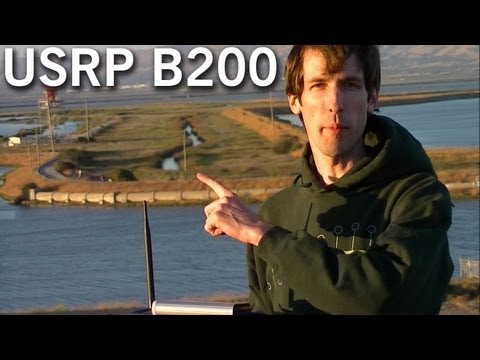

In [2]:
from IPython.display import YouTubeVideo
# A video on what you can do with Software defined radio. The B200 is a high-end SDR which is capable to much more than the rtl-sdr. 
# however, most of the stuff shown in the video could be done with the rtl-sdr as well. 
YouTubeVideo('cygDXeZaiOM')

In [5]:

# Import functions and libraries
from __future__ import division
import numpy as np, matplotlib.pyplot as plt
from numpy import *
from numpy.fft import *
from matplotlib.pyplot import *
import scipy.signal as signal
from rtlsdr import RtlSdr
import threading,time
import gc   # python garbage collection

#import bokeh.plotting as bk
#from bokeh.models import ColumnDataSource
#from bokeh.io import push_notebook
#bk.output_notebook()
#from IPython.html.widgets import interact


%matplotlib inline

## Task I: Capture data and compute the spectrum
Let's look at a simple example of acquring data and looking at its spectrum. NOAA weather radio is transmitted from San Francisco at 162.4MHz It is a 5KHz frequency modeulated (FM) audio signal that voices a recording of the weather. If you live in the east-bay, you might also be able to pick up the Mt. Diablo transmitter at 162.425MHz. Here's a map of the SF coverage:

<img src="https://inst.eecs.berkeley.edu/~ee123/sp14/lab/KHB49.png" alt="Drawing" style="height: 500px;"/>

It's best if you are outside of the building when collecting samples. Let's collect 4 seconds worth of samples ,sampled with a center frequency of 162MHz and a sampling rate of 960KHz.

To Instantiate the sdr with the following parameters, which create the rtlsdr object, set the center frequency and the sampling rate

    sdr = RtlSdr()
    sdr.set_sample_rate(960000)    # sampling rate
    sdr.set_center_freq(162200000)   # 162.2MhZ center frequency
    

In [3]:
# code here
sdr = RtlSdr()
sdr.set_sample_rate(960000)    # sampling rate
sdr.set_center_freq(162200000)   # 162.2MhZ center frequency

It is also useful to set the gain appropriately. The default is usually quite high and the signal saturates. 

To see what are the valid gains, invoke: 

    print(sdr.valid_gains_db)

The result will depend on the type of SDR you have (there are a few variants)

In [4]:
print(sdr.valid_gains_db)

[0.0, 0.9, 1.4, 2.7, 3.7, 7.7, 8.7, 12.5, 14.4, 15.7, 16.6, 19.7, 20.7, 22.9, 25.4, 28.0, 29.7, 32.8, 33.8, 36.4, 37.2, 38.6, 40.2, 42.1, 43.4, 43.9, 44.5, 48.0, 49.6]


Pick a number that's one or two slots larger than the middle (around 37.2 I found to be working well) and set the gain using
    sdr.set_gain(gain)
    

In [5]:
gain = 37.2
sdr.set_gain(gain)

The python interface to the SDR required that the number of samples be a multiple of 256. To read samples from the SDR, run the following command:

    N_samples = 960000*4 # 4 seconds
    y = sdr.read_samples(N_samples)   # get samples

If you are done with the device, you can clear it by:
    sdr.close()

In [13]:
# Your code here

N_samples = 960000*4 # 4 seconds
y_NOAA_samps = sdr.read_samples(N_samples)   # get samples
sdr.close()

In case you are having trouble with the SDR, uncomment the line below to load Miki's capture
``y = np.load('noaa.npy')``

In [67]:
#np.save('noaa.npy',y)
#print(len(y))
#In case you are having trouble with the SDR, uncomment the line below to load Miki's capture
#y = np.load('noaa.npy')

We will only use a small portion of it to process and look at the spectrum. Let’s crop the samples and analyze the spectrum of a portion of 16384 samples of it. We will use the function `fft` to compute the DFT and then `fftshift` to center the DFT around $\omega=0$. Remember, the signal you captured is complex valued, and hence has a two-sized spectrum. Intead of showing the spectrum in terms of $\omega$, plot it in terms of the physical frequencies. Use a Kaiser window with $\beta=6$. Use the function `plt.semilogy` to plot in log-scale. Make sure the axis is tight using `plt.axis` and that the aspect ratio of the figure is wide, so you can see the spectrum better



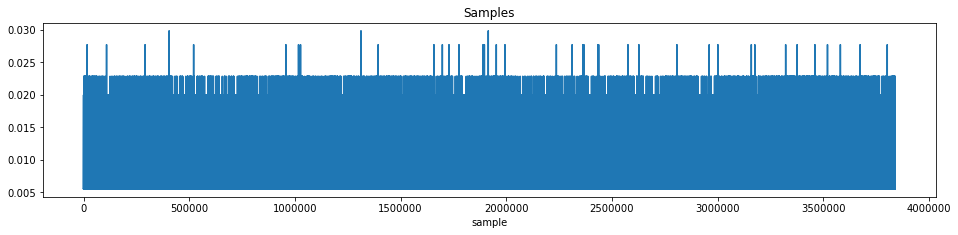

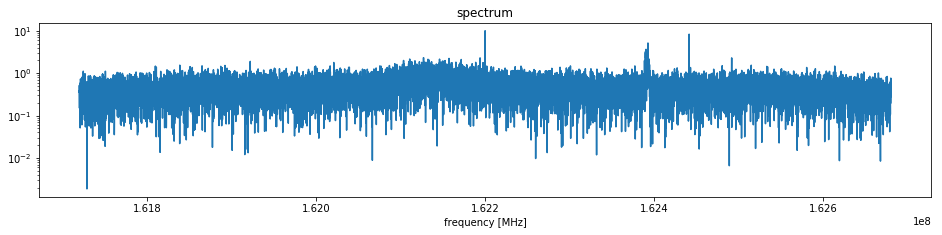

In [14]:
# Your Code here:
y_crop_0= y_NOAA_samps[:16384]
y_crop_1= y_NOAA_samps[10000:26384]

fc = 162200000
fs = 960000
f0 = fc-(fs//2)
f1 = fc+(fs//2)
L = 16384
Y = np.fft.fft(y_crop_0*np.kaiser(L,6))
Y_w = np.fft.fftshift(Y)
f = np.r_[f0:f1:(f1-f0)/L]

# The SDR returns samples at a desired rate up to 2.4MS/s 
# (sometimes 3.5MS/s) of a part of the spectrum around a desired center 
# frequency. For example, setting a center frequency  f0=88.5⋅106f0=88.5⋅106
# and a sampling rate of  Fs=2⋅106  will result in a complex valued 
# sequence  x[n]x[n] whos DTFT corresponds to the physical frequency range 
# of  87.5⋅10^6<f<89.5⋅10^6 . In other words, the digital 
# frequency  ω=0ω=0  of  X(ejω)X(ejω) , the DTFT of  x[n]x[n] , will 
# correspond to the physical frequency  88.588.5 MHz. The digital frequency  
# ω=πω=π  will correspond to  89.589.5 MHz and  ω=−πω=−π  will correspond to
# 87.587.5 MHz.

# Plot samps
width, height = figaspect(0.2)
fig=plt.figure(figsize=(width,height))
p = plt.plot(abs(y_NOAA_samps)), plt.xlabel('sample'); 
plt.title('Samples');

width, height = figaspect(0.2)
fig=plt.figure(figsize=(width,height))
p = plt.semilogy(f, abs(Y_w)), plt.xlabel('frequency [MHz]'); 
plt.title('spectrum');

You should be able to see some energy in the spectrum around the right frequency. However, what you will notice immediately is that the spectrum is noisy. In addition there might be some spurious peaks and in the white dongles (E4000) there is also a large peak at the DC frequency. The peak at the DC frequency is due to constant bias in the ADC of the device. This translates to an impulse at $\omega = 0$. Spourius peaks come from local oscillator leak and also quantization erros. 

To reduce the noise and get a finer look at the spectrum, we will break our entire sequence into smaller sequences. We don't need such a good spectral resolution, so we will break it to chunks sized 2048 samples, calculate their magnitude spectrum and average. This is also called average power specrum.

* Reshape the sequence into a matrix with row size of 2048. Remember that the ordering of the matrix is 'C' style and hence row-first. 
* Multiply the rows by a kaiser window with $\beta=6$
* Compute fft and fftshift along the 2nd dimension. 
* Compute the absolute square of the result and average along the 1st dimension
* Plot the result

In [15]:
# Yor code here:
shape = (len(y_NOAA_samps)//2048, 2048)
y_reshaped = np.reshape(y_NOAA_samps, shape)


for i in range(shape[0]): 
     y_reshaped[i] = y_reshaped[i]*np.kaiser(2048,6)
        
fft = np.fft.fft(y_reshaped, axis=1)
fftshift = np.fft.fftshift(fft, axes=1)

# compute mean
Pspect = mean(abs(fftshift)*abs(fftshift),axis=0);


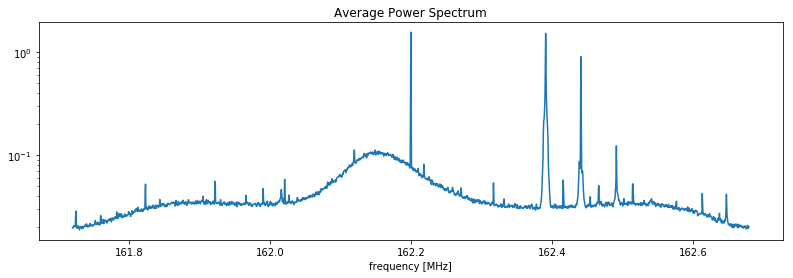

In [16]:
# Display:
N = 2048
f0= 162200000
f = r_[-N/2:N/2]/N*fs + f0

width, height = figaspect(0.3)
fig=plt.figure(figsize=(width,height))
p = plt.semilogy( f/1e6,Pspect);
plt.xlabel('frequency [MHz]'); plt.title('Average Power Spectrum');


This plot is called average power spectrum. As you can see, the spectrum looks much nicer now. Can you identify the NOAA weather station? Only the wide spectrum peaks are real. BTW, The very narrow spiky peaks in the spectrum are probably not real signals. They are due to leakage of the local oscilator, non-linearity in the receiver, and poor dynamic range of the ADC of the device. Still... for 12$ it is not too bad!


* What is the spectral resolution in the plot?
* Repeat the the measurement and the average power spectrum for the center frequency 88.4MHz. Can you identify NPR 88.5 Station?

Note: The rectangular bands you see around the main signal are HD radio signals. These are transmitted at the band edges and provide digital radio programming. Unfortunately HD radio in the USA uses proprietery protocol, and we can not decode it at this time. 

In [15]:
sdr = RtlSdr()
sdr.set_sample_rate(960000)    # sampling rate
sdr.set_center_freq(88400000)   # 162.2MhZ center frequency

In [16]:
print(sdr.valid_gains_db)

[0.0, 0.9, 1.4, 2.7, 3.7, 7.7, 8.7, 12.5, 14.4, 15.7, 16.6, 19.7, 20.7, 22.9, 25.4, 28.0, 29.7, 32.8, 33.8, 36.4, 37.2, 38.6, 40.2, 42.1, 43.4, 43.9, 44.5, 48.0, 49.6]


In [17]:
gain = 37.2
sdr.set_gain(gain)

In [18]:
N_samples = 960000*4 # 4 seconds
y_NPR_samps = sdr.read_samples(N_samples)   # get samples
sdr.close()

In [138]:
#np.save('npr.npy',y)

#In case you are having trouble with the SDR, uncomment the line below to load Miki's capture
#y = np.load('npr.npy')

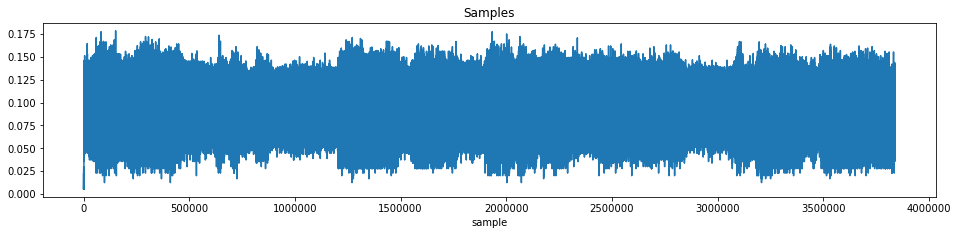

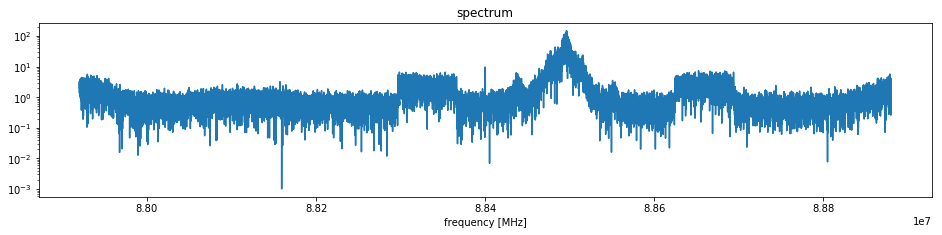

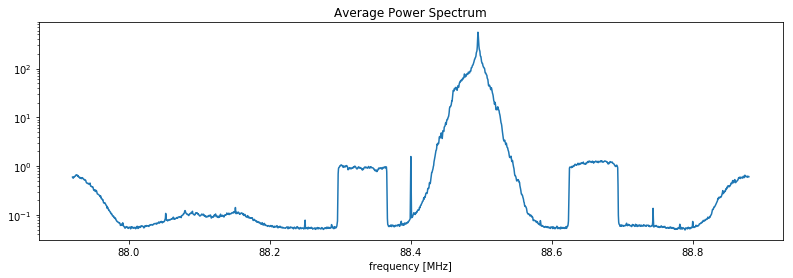

In [19]:
# Your Code here:
y_crop_0= y_NPR_samps[:16384]
#y_crop_1= y[10000:26384]

fc = 88400000
fs = 960000
f0 = fc-(fs//2)
f1 = fc+(fs//2)
L = 16384
Y = np.fft.fft(y_crop_0*np.kaiser(L,6))
Y_w = np.fft.fftshift(Y)
f = np.r_[f0:f1:(f1-f0)/L]

# The SDR returns samples at a desired rate up to 2.4MS/s 
# (sometimes 3.5MS/s) of a part of the spectrum around a desired center 
# frequency. For example, setting a center frequency  f0=88.5⋅106f0=88.5⋅106
# and a sampling rate of  Fs=2⋅106  will result in a complex valued 
# sequence  x[n]x[n] whos DTFT corresponds to the physical frequency range 
# of  87.5⋅10^6<f<89.5⋅10^6 . In other words, the digital 
# frequency  ω=0ω=0  of  X(ejω)X(ejω) , the DTFT of  x[n]x[n] , will 
# correspond to the physical frequency  88.588.5 MHz. The digital frequency  
# ω=πω=π  will correspond to  89.589.5 MHz and  ω=−πω=−π  will correspond to
# 87.587.5 MHz.

# Plot samps
width, height = figaspect(0.2)
fig=plt.figure(figsize=(width,height))
p = plt.plot(abs(y_NPR_samps)), plt.xlabel('sample'); 
plt.title('Samples');

width, height = figaspect(0.2)
fig=plt.figure(figsize=(width,height))
p = plt.semilogy(f, abs(Y_w)), plt.xlabel('frequency [MHz]'); 
plt.title('spectrum');

#Computing avg power spectrum:
shape = (len(y_NPR_samps)//2048, 2048)
y_reshaped = np.reshape(y_NPR_samps, shape)


for i in range(shape[0]): 
     y_reshaped[i] = y_reshaped[i]*np.kaiser(2048,6)
        
fft = np.fft.fft(y_reshaped, axis=1)
fftshift = np.fft.fftshift(fft, axes=1)

# compute mean
Pspect = mean(abs(fftshift)*abs(fftshift),axis=0);

N = 2048
f0= 88400000
f = r_[-N/2:N/2]/N*fs + f0

width, height = figaspect(0.3)
fig=plt.figure(figsize=(width,height))
p = plt.semilogy( f/1e6,Pspect);
plt.xlabel('frequency [MHz]'); plt.title('Average Power Spectrum');

## You are now ready to proceed to the next part. Make sure you kill this kernel to save memory

In [ ]:
%reset -f